# Classical Shadows for Entanglement Entropy

This notebook demonstrates how to use **classical shadows** to estimate 
entanglement entropy in the transverse-field Ising model (TFIM), following  
Huang *et al.*, *Nature Physics* **16**, 1050–1057 (2020),  
DOI: [10.1038/s41567-020-0932-7](https://doi.org/10.1038/s41567-020-0932-7).

- First, we compute exact ground state entanglement entropy as a function of $g/J$.  
- Then, we apply the **Pauli classical shadow scheme** to approximate the same quantity.  
- Finally, we compare exact results and shadow-based estimates.

The goal is to see how well classical shadows capture entanglement near the 
critical point $g/J \approx 1$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## TFIM model

We now study the ground state entanglement entropy as a function of the 
transverse field strength $g$ (with $J=1$).  

The Hamiltonian is:
$$
H = - J \sum_{i=1}^{N-1} Z_i Z_{i+1} - g \sum_{i=1}^N X_i,
$$
with $N$ spins in a 1D chain.

- For $g \ll J$: the system is ordered in the $Z$ direction (ferromagnetic phase).  
- For $g \gg J$: the system is disordered and polarized along $X$ (paramagnetic phase).  
- Around $g/J \approx 1$: a **quantum phase transition** occurs.

In [2]:
# Paul matrices
I = np.array([[1,0],[0,1]], dtype=complex)
X = np.array([[0,1],[1,0]], dtype=complex)
Y = np.array([[0,-1j],[1j,0]], dtype=complex)
Z = np.array([[1,0],[0,-1]], dtype=complex)

# op: operator (I, X, Y, Z), site: index of the spin, N: total number of spins
# Returns: operator matrix for the local operator at the specified site
def local_op(op, site, N):
    ops = [I]*N
    ops[site] = op
    return kron_n(ops)

# ops: list of operator matrices
# Returns: Kronecker product of the operators in the list
def kron_n(ops):
    out = np.array([[1]], dtype=complex)
    for op in ops:
        out = np.kron(out, op)
    return out

# N: number of spins, J: coupling strength, g: transverse field, periodic: True/False
# Returns: Ising Hamiltonian matrix H
def tfim_hamiltonian(N, J=1.0, g=1.0, periodic=True):
    H = np.zeros((2**N, 2**N), dtype=complex)

    def zz_coupling(i, j, N): # zz coupling operator for spins i and j
        ops = [I]*N
        ops[i] = Z; ops[j] = Z
        return kron_n(ops)
    
    for i in range(N-1):
        H -= J * zz_coupling(i, i+1, N)
    if periodic and N>2:
        H -= J * zz_coupling(N-1, 0, N)
    for i in range(N):
        H -= g * local_op(X, i, N)
    return H

# H: Hamiltonian matrix
# Returns: density matrix |psi0><psi0| for the ground state of H
def ground_state_rho(H):
    evals, evecs = np.linalg.eigh(H)
    psi0 = evecs[:, np.argmin(evals)]
    return np.outer(psi0, psi0.conj())

# rho: density matrix, keep: list of spins to keep, N: total number of spins
# Returns: reduced density matrix after tracing out the specified spins
def partial_trace(rho, keep, N):
    keep = sorted(keep)
    all_idx = list(range(N))
    trace_out = [i for i in all_idx if i not in keep]
    dims = [2]*N
    d_keep = 2**len(keep); d_tr = 2**(N-len(keep))
    rho_t = rho.reshape(dims + dims)
    perm = keep + trace_out + [i+N for i in keep] + [i+N for i in trace_out]
    rho_p = np.transpose(rho_t, axes=perm).reshape(d_keep, d_tr, d_keep, d_tr)
    rho_keep = np.einsum('abcb->ac', rho_p)
    return rho_keep

# rho: density matrix, type: 'vN' for von Neumann entropy or 'R2' for Renyi-2 entropy
# Returns: entropy value (von Neumann or Renyi-2)
def entropy(rho, type ='vN'):
    evals = np.linalg.eigvalsh(rho)
    evals = np.clip(evals.real, 1e-12, 1.0)
    if type == 'R2': return -np.log2(np.sum(evals**2))  # Renyi-2 entropy
    return -np.sum(evals * np.log2(evals))              # von Neumann entropy

We compute the **ground state entanglement entropy** of the one third of the chain, 
$$
S(\rho_A) = - \mathrm{Tr} \big( \rho_A \log \rho_A \big),
$$
where $\rho_A = \mathrm{Tr}_B(|\psi\rangle \langle \psi|)$ is the reduced density matrix 
of the block $A$.

By sweeping $g/J$ for various system sizes $N$, the entanglement entropy 
shows a peak near the critical point, signaling the phase transition.

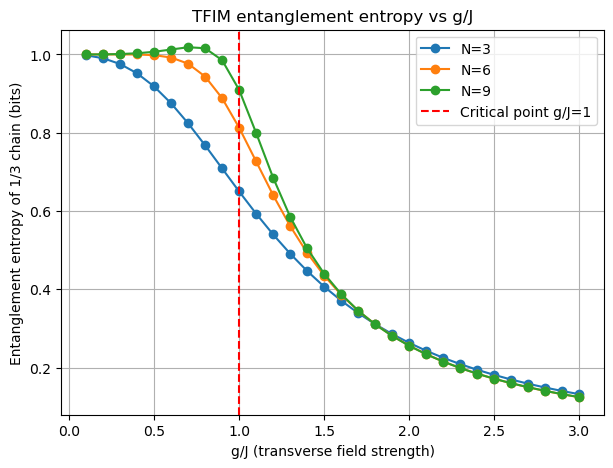

In [ ]:
J = 1.0
g_list = np.linspace(0.1, 3.0, 30)   # sweep transverse field strength
N_list = [3, 6, 9]

plt.figure(figsize=(7,5))

for N in N_list:
    block = list(range(N//3))  # one third of the chain
    S_list = []                # entanglement entropy list for this N
    for g in g_list:
        H = tfim_hamiltonian(N, J=J, g=g, periodic=True)
        rho = ground_state_rho(H)             # ground state density matrix
        rhoA = partial_trace(rho, block, N)   # reduced density matrix
        S = entropy(rhoA)
        S_list.append(S)
    
    plt.plot(g_list, S_list, marker='o', label=f"N={N}")

# critical point g/J=1
plt.axvline(x=1.0, color='r', linestyle='--', label="Critical point g/J=1")

plt.xlabel("g/J (transverse field strength)")
plt.ylabel("Entanglement entropy of 1/3 chain (bits)")
plt.title("TFIM entanglement entropy vs g/J")
plt.legend()
plt.grid(True)
plt.show()

## Classical Shadows (Pauli scheme)

Huang *et al.* (2020) propose two ensembles for classical shadows:  
(i) global $n$-qubit Clifford unitaries, and  
(ii) tensor products of single-qubit Clifford circuits.  
Here we adopt (ii). In practice this reduces to **random Pauli measurements** on each qubit, because
measuring in $X,Y,Z$ can be implemented by single-qubit Cliffords followed by a Z-basis readout:
$U_X=H$, $U_Y=S^\dagger H$, $U_Z=I$.

Per shot

1. **Choose a local Pauli basis** $b=(b_1,\dots,b_n)\in\{X,Y,Z\}^{\otimes n}$ uniformly at random.  
2. **Measure** in that basis to obtain a bitstring $\mathbf{b}=(b_1^\text{out},\dots,b_n^\text{out})\in\{0,1\}^n$.  
3. **Apply the inverse channel** (classical post-processing) to form a *single-shot shadow* $\hat\rho_i$.

In [4]:
import numpy as np
from tqdm import tqdm

# ---- small helpers (reuse your existing ones if already defined) ----
def rot_to_Z(b):
    if b == 'Z': return np.eye(2, dtype=complex)
    if b == 'X': return (1/np.sqrt(2))*np.array([[1,1],[1,-1]], dtype=complex)
    if b == 'Y':
        Sdg = np.array([[1,0],[0,-1j]], dtype=complex)
        H   = (1/np.sqrt(2))*np.array([[1,1],[1,-1]], dtype=complex)
        return Sdg @ H
    raise ValueError(b)

def one_qubit_projector(b, bit):
    if b == 'Z':
        v = np.array([1,0], complex) if bit==0 else np.array([0,1], complex)
    elif b == 'X':
        v = (1/np.sqrt(2))*np.array([1, 1], complex) if bit==0 else (1/np.sqrt(2))*np.array([1,-1], complex)
    else:  # 'Y'
        v = (1/np.sqrt(2))*np.array([1, 1j], complex) if bit==0 else (1/np.sqrt(2))*np.array([1,-1j], complex)
    return np.outer(v, v.conj())

def one_qubit_shadow_estimator(b, bit):
    P = one_qubit_projector(b, bit)
    return 3.0*P - np.eye(2, dtype=complex)  # Tr = 1

def kron_n(ops):
    out = np.array([[1.0+0j]], dtype=complex)
    for op in ops:
        out = np.kron(out, op)
    return out

def sample_outcome_bits(rho, basis, rng):
    """Sample ONE joint outcome from diag(U rho U†) (Born rule)."""
    U = kron_n([rot_to_Z(b) for b in basis])             # 512x512 for N=9
    rho_rot = U @ rho @ U.conj().T
    probs = np.real_if_close(np.diag(rho_rot)).astype(float)
    probs = np.clip(probs, 0.0, None); probs /= probs.sum()
    N = len(basis)
    idx = rng.choice(probs.size, p=probs)
    return np.array([(idx >> (N-1-k)) & 1 for k in range(N)], dtype=int)

# ---- streamed purity on block A: no 512x512 storage, no list ----
def purity_streamed_Ustat_on_block(rho, N, keep, shots, rng, desc=None):
    """
    Build Ai^A as kron over kept qubits only and stream the U-statistic:
      purity = (m^2 Tr(Abar^2) - sum Tr(Ai^2)) / (m(m-1)).
    """
    m = shots
    dA = 2**len(keep)

    sumA   = np.zeros((dA, dA), dtype=complex)  # Σ Ai
    sumTr2 = 0.0                                # Σ Tr(Ai^2)

    # Precompute index masks
    keep_set = set(keep)
    keep_idx = [k for k in range(N) if k in keep_set]

    iterator = tqdm(range(m), desc=desc, leave=False) if desc else range(m)
    for _ in iterator:
        # random local Pauli basis
        basis = rng.choice(np.array(['X','Y','Z']), size=N)
        # sample joint outcome
        bits  = sample_outcome_bits(rho, basis, rng)
        # build 2x2 ops only on kept sites; traced sites contribute factor 1
        ops_keep = [one_qubit_shadow_estimator(basis[q], int(bits[q])) for q in keep_idx]
        AiA = kron_n(ops_keep)                      # dA x dA (here 16x16)
        sumA   += AiA
        sumTr2 += np.trace(AiA @ AiA).real

    Abar = sumA / m
    num  = (m*m) * np.trace(Abar @ Abar).real - sumTr2
    purity = num / (m*(m-1))
    # stabilize slightly below 1 to avoid S2=0 sticking
    purity = float(np.clip(purity, 1e-6, 1.0 - 1e-9))
    return purity

def S2_from_purity(pur, s2_max_bits=None):
    S2 = -np.log2(pur)
    if s2_max_bits is not None:
        S2 = min(S2, s2_max_bits)
    return S2

### Inverse channel (single-qubit Pauli)

Let $\mathcal{M}_1$ denote the single-qubit measurement channel that averages over Pauli bases/outcomes.
Its inverse acts on an operator $X$ as

$$
\mathcal{M}_1^{-1}(X) \;=\; 3\,X \;-\; \mathrm{Tr}(X)\,I .
$$

Applying this to the **measured projector in the lab frame**
$P_k = U_{b_k}^\dagger \,|b_k^\text{out}\rangle\!\langle b_k^\text{out}|\, U_{b_k}$ gives the local shadow

$$
\hat{\rho}^{(1)}_k \;=\; \mathcal{M}_1^{-1}(P_k)
\;=\; 3\,P_k - I
\;=\; 3\,U_{b_k}^\dagger \,|b_k^\text{out}\rangle\!\langle b_k^\text{out}|\, U_{b_k} - I .
$$

Because measurements are chosen independently per qubit, the **$n$-qubit inverse channel factorizes**:

$$
\mathcal{M}^{-1} \;=\; \bigotimes_{k=1}^n \mathcal{M}_1^{-1},
\qquad
\hat{\rho}_i \;=\; \bigotimes_{k=1}^n \hat{\rho}^{(1)}_k .
$$

This ensures **unbiasedness**:
$\;\mathbb{E}_{b,\text{out}}[\hat{\rho}_i] = \rho$.

In [6]:
# Build rho from your saved |psi_g1| (N=9, g/J≈1)
# If psi_g1 already defined from your previous cell:
rho_g1 = ground_state_rho(tfim_hamiltonian(N, J=J, g=g, periodic=True))

keep = list(range(N//2))          # half-chain A
rng  = np.random.default_rng(123)
shots = 2000

# Exact S2 for reference
rhoA = partial_trace(rho_g1, keep=keep, N=N)
tr2  = np.trace(rhoA @ rhoA).real
S2_exact = -np.log2(max(tr2, 1e-12))

# Streamed shadows (no big allocations)
pur = purity_streamed_Ustat_on_block(
    rho_g1, N=N, keep=keep, shots=shots, rng=rng,
    desc=f"N={N}, g/J≈1, shots={shots}"
)
S2_shadow = S2_from_purity(pur, s2_max_bits=len(keep))

print(f"Exact S2  : {S2_exact:.3f} bits")
print(f"Shadow S2 : {S2_shadow:.3f} bits  (streamed U-stat, no OOM)")

Exact S2  : 0.042 bits
Shadow S2 : 0.000 bits  (streamed U-stat, no OOM)


### Estimating block entropy

From many shots we reduce each shadow to the subsystem $A$:
$\hat{\rho}_i^A = \mathrm{Tr}_{\bar A}[\hat{\rho}_i]$.
We then estimate the block purity with a **U-statistic** using all pairs of shadows:

$$
\widehat{\mathrm{Tr}(\rho_A^2)}
= \frac{m^2\,\mathrm{Tr}(\bar{\rho}_A^2) \;-\; \sum_{i=1}^m \mathrm{Tr}\!\big[(\hat{\rho}_i^A)^2\big]}
{m(m-1)} ,
\quad
\bar{\rho}_A=\frac{1}{m}\sum_{i=1}^m \hat{\rho}_i^A .
$$

Finally we report the **Rényi-2 entropy**

$$
S_2(A) \;=\; -\log_2 \mathrm{Tr}(\rho_A^2) .
$$

**Notes.**
- We restrict to Pauli axes $X,Y,Z$ (a subset of the 24 single-qubit Cliffords); this is standard and experimentally convenient.
- For robustness we aggregate across trials via **median-of-means** and clip tiny purity estimates before the $-\log_2$ to avoid numerical blow-ups.

In [ ]:
# Compute S2 from a list of reduced shadow ops {ρ̂_i^A}.
# Uses unbiased U-statistic for purity and clips small values before -log2.
# block_ops: list of reduced shadow operators, eps: small value for numerical stability, s2_max_bits: optional upper bound for S2 in bits
# Returns: S2 estimate for the subsystem defined by the reduced shadow operators
def s2_from_shadows(block_ops, eps=1e-6, s2_max_bits=None):
    m = len(block_ops)
    if m < 2:
        return np.nan

    block_ops = [(A + A.conj().T)/2 for A in block_ops] # Hermitian symmetrization (numerical stability)

    # U-statistic for Tr(ρ_A^2):
    diag_sum = sum(np.trace(A @ A).real for A in block_ops)
    Abar = sum(block_ops) / m
    num = (m*m) * np.trace(Abar @ Abar).real - diag_sum
    purity = num / (m*(m-1))

    # stabilize & convert to bits
    purity = float(np.clip(purity, eps, 1.0))
    S2 = -np.log2(purity)

    if s2_max_bits is not None:
        S2 = min(S2, s2_max_bits)
    return S2

# Perform one shadow estimation run with `shots` measurements.
# rho: density matrix, keep: list of spins to keep, N: total number of spins, 
# shots: number of measurements, rng: random number generator, eps: small value for numerical stability
# Returns: S2 estimate on the subsystem defined by `keep`
def estimate_shadow_S2_once(rho, keep, N, shots, rng, eps=1e-6):
    block_ops = []
    for _ in range(shots):
        basis = sample_random_pauli_basis(N, rng)
        bits  = sample_outcome_bits(rho, basis, rng)      # joint sample
        hat_rho   = single_shadow_operator(basis, bits)   # inverse channel applied
        hat_rho_A = reduce_to_block(hat_rho, keep=keep, N=N)
        block_ops.append(hat_rho_A)

    return s2_from_shadows(block_ops, eps=eps, s2_max_bits=len(keep))

In [ ]:
# Robust center & scale from median of means.
# values: array of values, G: number of groups to split the data into
# Returns: center and scale (median of means and MAD of means)
def median_of_means(values, G=8):
    """Robust center & scale from median of means."""
    import numpy as np
    vals = np.asarray(values, float)
    n = len(vals)
    G = max(1, min(G, n))
    k = n // G
    if k == 0:
        center = float(np.median(vals))
        scale  = float(1.4826 * np.median(np.abs(vals - center)))  # MAD→σ
        return center, scale

    blocks = [vals[i*k:(i+1)*k] for i in range(G-1)]
    blocks.append(vals[(G-1)*k:])  # 마지막 블록은 남은 전부
    means = np.array([b.mean() for b in blocks if len(b)>0], float)
    med   = float(np.median(means))
    # robust scale: MAD of block means
    mad   = float(1.4826 * np.median(np.abs(means - med)))
    return med, mad

## Paramters for TFIM model

In [ ]:
N = 9       # number of spins
J = 1.0     # coupling strength
g = 1.0     # transverse field
periodic = True # periodic boundary condition
block = 4       # block size for the shadow entropy calculation
T_min, T_max = 0.05, 10.0   # temperature range
nT = 10     # number of temperature points

shots_list = [100, 200, 400, 800, 1600, 3200] # number of shots for each temperature
rng_seed = 0        # random seed for reproducibility
bootstrap_K = 64    # for error bars

# Run sweep: Exact S2 for reference + shadow S2 (no trials, only shots)

rng = np.random.default_rng(rng_seed)
H = tfim_hamiltonian(N, J=J, g=g, periodic=True)
Ts = np.geomspace(T_min, T_max, nT)
keep = list(range(block))

S2_exact = []
S2_shadow_means = {m: [] for m in shots_list}
S2_shadow_stds  = {m: [] for m in shots_list}

for idxT, T in enumerate(Ts, 1):
    beta = 1.0 / T
    rho = thermal_state(H, beta)
    rhoA = partial_trace(rho, keep=keep, N=N)

    # --- Exact S2 (entropy only)
    tr2 = np.real(np.trace(rhoA @ rhoA))
    S2_exact.append(float(-np.log2(max(tr2, 1e-12))))

    # --- Shadow estimates (single batch with m shots)
    for m in shots_list:
        block_ops = []
        for _ in range(m):   # m번 샷
            basis = sample_random_pauli_basis(N, rng)
            bits  = sample_outcome_bits(rho, basis, rng)
            hat_rho   = single_shadow_operator(basis, bits)
            hat_rho_A = reduce_to_block(hat_rho, keep=keep, N=N)
            block_ops.append(hat_rho_A)

        # 바로 S2 추정
        S2_est = s2_from_shadows(block_ops, eps=1e-6, s2_max_bits=len(keep))
        S2_shadow_means[m].append(S2_est)
        S2_shadow_stds[m].append(0.0)  # trial 없으니 에러바 없음

    # 진행률 출력
    if idxT % max(1, nT//10) == 0 or idxT == nT:
        print(f"[{idxT:02d}/{nT}] T={T:.4g} done")

# numpy array 변환
S2_exact = np.array(S2_exact)
for m in shots_list:
    S2_shadow_means[m] = np.array(S2_shadow_means[m])
    S2_shadow_stds[m]  = np.array(S2_shadow_stds[m])

[01/10] T=0.05 done
[02/10] T=0.09008 done
[03/10] T=0.1623 done
[04/10] T=0.2924 done
[05/10] T=0.5268 done
[06/10] T=0.9491 done
[07/10] T=1.71 done
[08/10] T=3.081 done
[09/10] T=5.55 done
[10/10] T=10 done


## Reading the plot

- **Black line**: exact \(S_2(\rho_A)\).
- **Colored lines**: shadow-based \(S_2\) for different shot counts.
- Shaded bands: robust dispersion (median-of-means, \(\sim\)1σ).
- As shots increase, shadow curves should approach the exact line and smooth out.

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5), dpi=120)

# Exact curve
plt.plot(
    Ts, S2_exact, 
    marker='o', color='black', lw=2, ms=6, 
    label="Exact S2"
)

# Shadow curves
colors = plt.cm.Set1.colors  # nice categorical palette
for i, m in enumerate(shots_list):
    mean = S2_shadow_means[m]
    std  = S2_shadow_stds[m]
    plt.plot(
        Ts, mean, 
        marker='s', lw=1.8, ms=5, 
        color=colors[i % len(colors)], 
        label=f"Shadow S2 (shots={m})"
    )
    plt.fill_between(
        Ts, mean-std, mean+std, 
        color=colors[i % len(colors)], alpha=0.2
    )

# Styling
plt.xlabel("Temperature $T$", fontsize=12)
plt.ylabel(r"Rényi-2 entropy $S_2(A)$ [bits]", fontsize=12)
plt.title(
    fr"Classical Shadows (Pauli) — TFIM $N={N}, g/J={g/J:.2f}, \mathrm{{block}}={block}$", 
    fontsize=13
)
plt.grid(True, which="both", ls="--", lw=0.6, alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=10)

# Legend outside
plt.legend(frameon=False, fontsize=10, loc="center left", bbox_to_anchor=(1,0.5))

plt.tight_layout()
plt.show()

NameError: name 'Ts' is not defined

## Takeaways

- \(T \uparrow\) generally increases \(S_2\) as the block becomes more mixed/entangled.
- Near \(g/J \approx 1\), finite-\(T\) **crossovers** replace the \(T=0\) critical singularity.
- With more shots, classical-shadow estimates get closer to the exact curve while the error band narrows.